<a href="https://colab.research.google.com/github/Wilsonmfreire/MACHINE-LEARNING-CONCEITOS-APLICA-ES-e-ESTUDO-DE-CASO/blob/main/Pyspark_para_Ci%C3%AAncia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Aprendizado de máquina a partir de desastres

 Aprendizado de máquina para criar um modelo que preveja quais passageiros sobreviveram ao naufrágio do Titanic.

In [54]:
#install Apache Spark
!pip install pyspark --quiet

In [55]:
# start no ambiente
from pyspark.sql import SparkSession
from pyspark.sql.functions import round, desc

spark = SparkSession.builder.appName("Machine-Learning").master("local[*]").getOrCreate()

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession
from pyspark.ml  import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

# Breve explicação do que é o spark e como podemos utilizar
O Spark visa velocidade leve, facilidade de uso e extensibilidade em sistemas de dados muito grandes. Empresas com grandes data centers geralmente implantam modelos no Spark para obter benefícios robustos e escaláveis ​​no nível de produção. O Spark introduziu APIs de alto nível em Java, Scala, Python e R. Eu uso o Pyspark pela familiaridade.

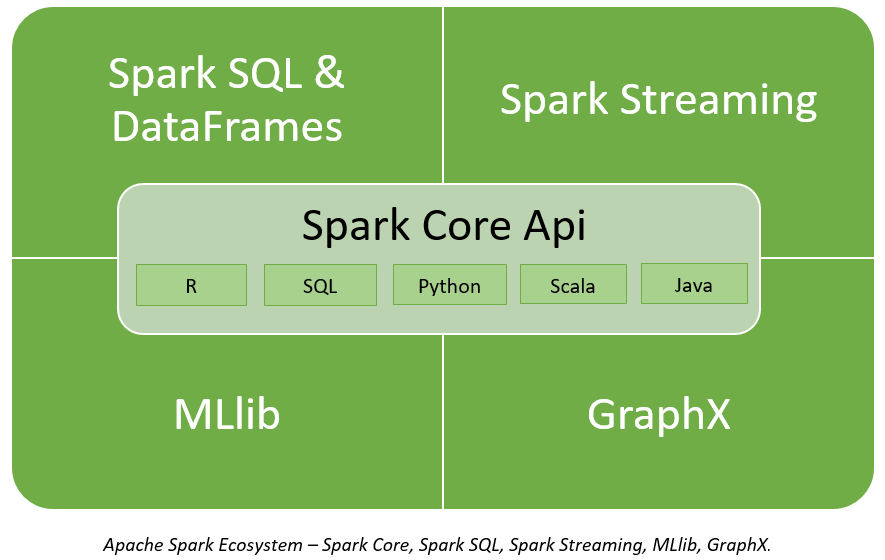

## Trabalhando com indicações de filmes para usuários específicos
Nessa fase vamos só ver algumas funções e o poder de criação e processamento so pyspark

In [57]:
# carregando o conjunto de dados e cria o dataframe
df=spark.read.csv('/content/sample_data/movie_ratings_df.csv',inferSchema=True,header=True)

df.limit(3).toPandas()

,userId,title,rating
0,196,Kolya (1996),3
1,63,Kolya (1996),3
2,226,Kolya (1996),5


Como podemos ver, a coluna do título é armazenada como tipo string. Para trabalhar com a biblioteca pyspark Mlib, precisamos converter o tipo de string em valores numéricos

In [58]:
from pyspark.ml.feature import StringIndexer, IndexToString
stringIndexer = StringIndexer(inputCol='title', outputCol='title_new')
# Aplicando objeto stringindexer na coluna de título do filme dataframe
model = stringIndexer.fit(df)

indexed = model.transform(df)

indexed.limit(5).toPandas()

,userId,title,rating,title_new
0,196,Kolya (1996),3,287.0
1,63,Kolya (1996),3,287.0
2,226,Kolya (1996),5,287.0
3,154,Kolya (1996),3,287.0
4,306,Kolya (1996),5,287.0


In [59]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



Usamos o algoritmo Alternating Least Squares (ALS) na biblioteca Pyspark Ml

In [60]:
#dividindo os dados em conjunto para treinamento e teste
train, test = indexed.randomSplit([0.75,0.25])
from pyspark.ml.recommendation import ALS

#Treinando o modelo de recomendação usando conjunto de dados de treinamento
rec=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='userId'
        ,itemCol='title_new'
        ,ratingCol='rating'
        ,nonnegative=True
        ,coldStartStrategy="drop")

rec_model=rec.fit(train)

predicted_ratings=rec_model.transform(test)
predicted_ratings.limit(5).toPandas()

,userId,title,rating,title_new,prediction
0,148,Cold Comfort Farm (1995),5,262.0,3.797441
1,148,Fantasia (1940),5,153.0,3.887599
2,148,Four Weddings and a Funeral (1994),5,66.0,4.885172
3,148,"Godfather, The (1972)",1,11.0,4.305775
4,148,Henry V (1989),2,269.0,4.678658


Avaliando treinamento

In [61]:
# Importando avaliador de regressão para medir RMSE
from pyspark.ml.evaluation import RegressionEvaluator
# cria o objeto avaliador Regressor para medir a precisão
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='rating')
# aplica o RE no dataframe de previsões para calcular o RMSE
rmse=evaluator.evaluate(predicted_ratings)
# print em RMSE para erros
print(rmse)

1.034498823202713


Após o treinamento, agora é a hora de recomendar os melhores filmes que o usuário possa gostar

In [62]:
# Primeiro precisamos criar um conjunto de dados de todos os filmes distintos
unique_movies=indexed.select('title_new').distinct()

#criar função para recomendar os melhores filmes para qualquer usuário específico
def top_movies(user_id,n):
    """
    This function returns the top 'n' movies that user has not seen yet but might like

    """
    #atribuindo nome alternativo 'a' para filmes exclusivos d
    a = unique_movies.alias('a')

    #criando outro dataframe que contém filme já assistido pelo usuário ativo
    watched_movies=indexed.filter(indexed['userId'] == user_id).select('title_new')

    #atribuindo nome alternativo 'b' para filmes assistidos df
    b=watched_movies.alias('b')

    #jjoin em ambas as tabelas
    total_movies = a.join(b, a.title_new == b.title_new,how='left')

    #selecionando filmes que o usuário ativo ainda não avaliou ou assistiu
    remaining_movies=total_movies.where(col("b.title_new").isNull()).select(a.title_new).distinct()


    #adicionando nova coluna de user_Id do usuário ativo aos filmes restantes df
    remaining_movies=remaining_movies.withColumn("userId",lit(int(user_id)))


    #fazendo recomendações usando o modelo de recomendação ALS e selecionando apenas os melhores filmes
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)


    #adicionando colunas de títulos de filmes nas recomendações
    movie_title = IndexToString(inputCol="title_new", outputCol="title",labels=model.labels)
    final_recommendations=movie_title.transform(recommendations)

    #devolver as recomendações ao usuário ativo
    return final_recommendations.show(n,False)

In [63]:
# Test: recommend 5 movies for user of id=60
top_movies(60,5)

+---------+------+----------+---------------------------------------+
|title_new|userId|prediction|title                                  |
+---------+------+----------+---------------------------------------+
|1347.0   |60    |5.7233553 |Angel Baby (1995)                      |
|1120.0   |60    |5.6153574 |Crooklyn (1994)                        |
|1103.0   |60    |5.545792  |Stalker (1979)                         |
|926.0    |60    |5.4871874 |Ma vie en rose (My Life in Pink) (1997)|
|706.0    |60    |5.420462  |Priest (1994)                          |
+---------+------+----------+---------------------------------------+



## Modelo de classificação no Pyspark

Estamos usando o conjunto de dados do Titanic para nos familiarizarmos com dados baseados no Pyspark DataFrame

In [64]:
# Nova sessao sparkSession (like a container)
spark = SparkSession.builder.appName('Brincando com pyspark ML em titatic_dataset').getOrCreate()
# Lendo arquivo com pandas
df = spark.read.csv('/content/sample_data/train.csv',header = 'True',inferSchema='True')

In [65]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [66]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



Para visualização, antes de usar a biblioteca visual (matplotlib, seaborn, ..) precisamos converter SparkDataframe em PandasDataFrame¶

<ipython-input-68-657a39a150a1>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df['Age']);


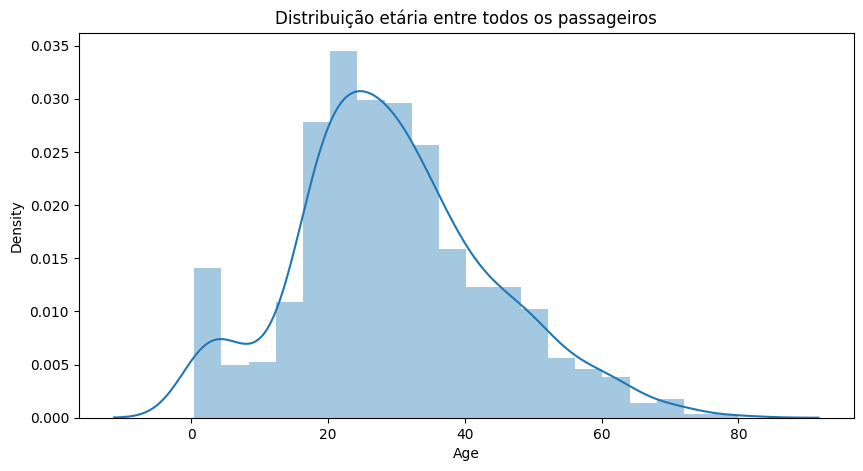

In [68]:
pandas_df = df.toPandas()

plt.figure(figsize=(10,5))
plt.title('Distribuição etária entre todos os passageiros')
sns.distplot(pandas_df['Age']);

### Verificando valores nulos no Pyspark
* isnan() é uma função do pacote pysparq.sql.function, temos que definir qual coluna queremos usar como argumento da função.
* isNull()" pertence ao pacote pyspark.sql.Column, para verificar o status nulo de uma coluna

Para verificar nulo no Pyspark, usamos as duas funções acima

In [20]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [22]:
# Como a coluna Cabin tem muitos valores ausentes (> 50%), então podemos removê-la
df = df.drop("Cabin")

Para substituir esses valores NaN, podemos atribuir-lhes a idade média do conjunto de dados. Mas o problema é que havia muitas pessoas com idades diferentes. </br>
No recurso 'Nome', podemos ver que os nomes possuem uma saudação como Sr. ou Sra. Assim, podemos atribuir os valores médios de Sr. e Sra. aos respectivos grupos </br>
Usando o Regex ""[A-Za-z]+)."extraímos as iniciais do Nome. Ele procura strings que estejam entre A-Z ou a-z e seguidas por um .(ponto).

In [23]:
df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [25]:
# Existem algumas iniciais com erros ortográficos, como Mlle ou Mme, que significam Miss. Iremos substituí-las por Miss e a mesma coisa para outros valores.
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Verificando a idade média pelas iniciais
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [26]:
# Atribuição de valores ausentes no recurso de idade com base na idade média das iniciais
df = df.withColumn("Age",when((df["Initial"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))

In [27]:
# Colunas embarcadas possuem dois valores faltantes, vamos verificar
df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



Estamos usando PysparkDataFrame.na.fill() para preencher um valor em uma coluna específica

In [28]:
# Como podemos ver, a maioria dos passageiros embarcou em "S". Podemos atribuir valor ausente com "S"
df = df.na.fill({"Embarked" : 'S'})
# Check again the missing value status
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



Depois de trabalhar os valores null, vamos usar alguns recursos simples como condições múltiplas do pyspark em sintaxe como : "Quando caso contrário"

In [29]:
df = df.withColumn("Family_Size",col('SibSp')+col('Parch')) # Cria nova coluna: Family_size
df = df.withColumn('Alone',lit(0))  # Criando nova coluna: Alone para o valor padrao 0
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))

# convertendo colunas Sex, Embarked e Initial de string para número usando StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [30]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0


In [31]:
# Agora descartamos colunas que não são necessárias para modelagem
df = df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

# Antes de modelar no Pyspark, precisamos colocar todos os recursos no Vector usando o Pyspark VectorAssembler
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


In [32]:
# para divisão de dados no pyspark, podemos usar df.randomSplit()
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

In [33]:
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



## Machine learning no pyspark
Apenas para praticar, usarei alguns algoritmos de aprendizagem:
 1. LogisticRegression
 2. RandomForestClassifier
 3. Gradient-boosted


In [35]:
# Selecione a coluna de recursos para treinamento de recursos e 'Survived' como rótulo para prever
titanic_df = feature_vector.select(['features','Survived'])
# Divida o conjunto de dados em train_df e test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

### Regressão logística

In [36]:
# CARREGANDO PYSPARK LIBRARIES
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# DEFININDO ALGORITIMOS
lr = LogisticRegression(labelCol="Survived")

# DEFININDO PARAMETROS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# DEFININDO VALIDAÇÃO CRUZADA COM PARÂMETROS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8199052132701422
Precision:  0.8209138954700248


### Avaliando a métrica ROC

In [38]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
results = model_predictions.select(['probability', 'Survived'])

## preparar conjunto de rótulos de pontuação
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("A pontuação ROC é : ", metrics.areaUnderROC)

A pontuação ROC é :  0.8872720574691472


### Visualizando métricas de AUC

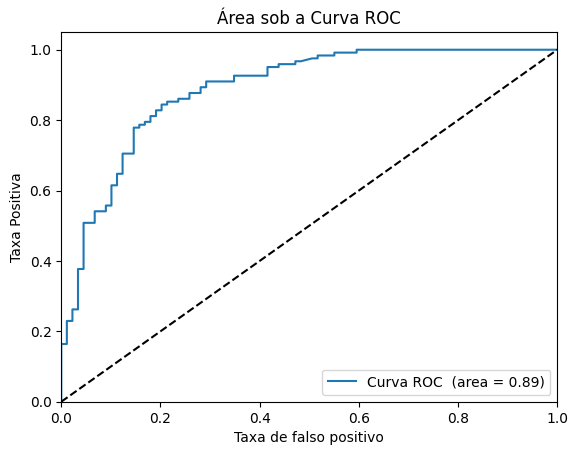

In [40]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC  (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa Positiva')
plt.title('Área sob a Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Floresta Aleatória


In [41]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=rf
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)


print('Acuracia: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precisao: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Acuracia:  0.8199052132701422
Precisao:  0.8268995800477708


### Avaliando métricas ROC


In [42]:
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])

## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("A pontuação ROC é : ", metrics.areaUnderROC)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


A pontuação ROC é :  0.8599189537668077


### Visualizando métricas AUC


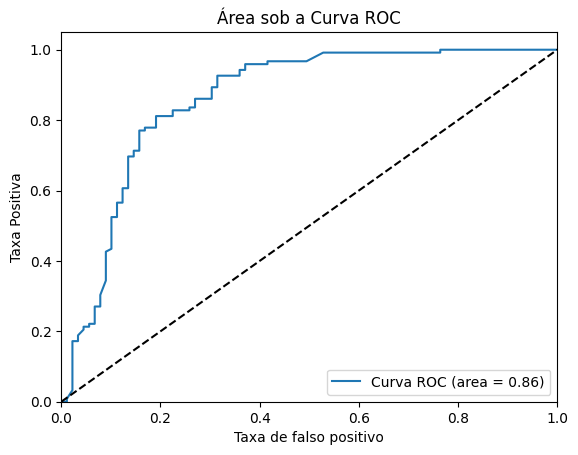

In [43]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa Positiva')
plt.title('Área sob a Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Árvore melhorada

In [44]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Survived")
paramGrid = ParamGridBuilder()\
                            .addGrid(gbt.maxDepth, [5, 10, 20]) \
                            .addGrid(gbt.maxBins, [20, 32, 50]) \
                            .addGrid(gbt.maxIter, [10, 20, 30]) \
                            .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
                            .build()

tvs = TrainValidationSplit(estimator=gbt
                           , estimatorParamMaps=paramGrid
                            ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                            ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)
print('acuracia: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precisao: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

acuracia:  0.8009478672985783
Precisao:  0.8006842678388661


### Avaliando a métrica ROC

In [45]:
sc =SparkContext.getOrCreate()
results = model_predictions.select(['probability', 'Survived'])

## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("A pontuação ROC é : ", metrics.areaUnderROC)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


A pontuação ROC é :  0.8425124332289555


### Visualizando métricas de AUC

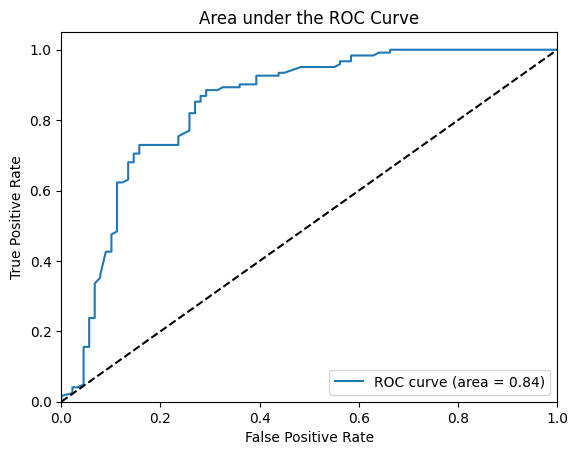

In [46]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()